In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# 1. Read data from CSV file
#RawData[][0] = time, RawData[][1] = position, RawData[][2] = acceleration
RawData = np.array(pd.read_csv('cleaneddata.csv').values)
FilteredData = np.array(pd.read_csv('filteredData.csv').values)

print(RawData[1,2], FilteredData[1,1])

9.79 -1.69


7652 7652


<Figure size 640x480 with 0 Axes>

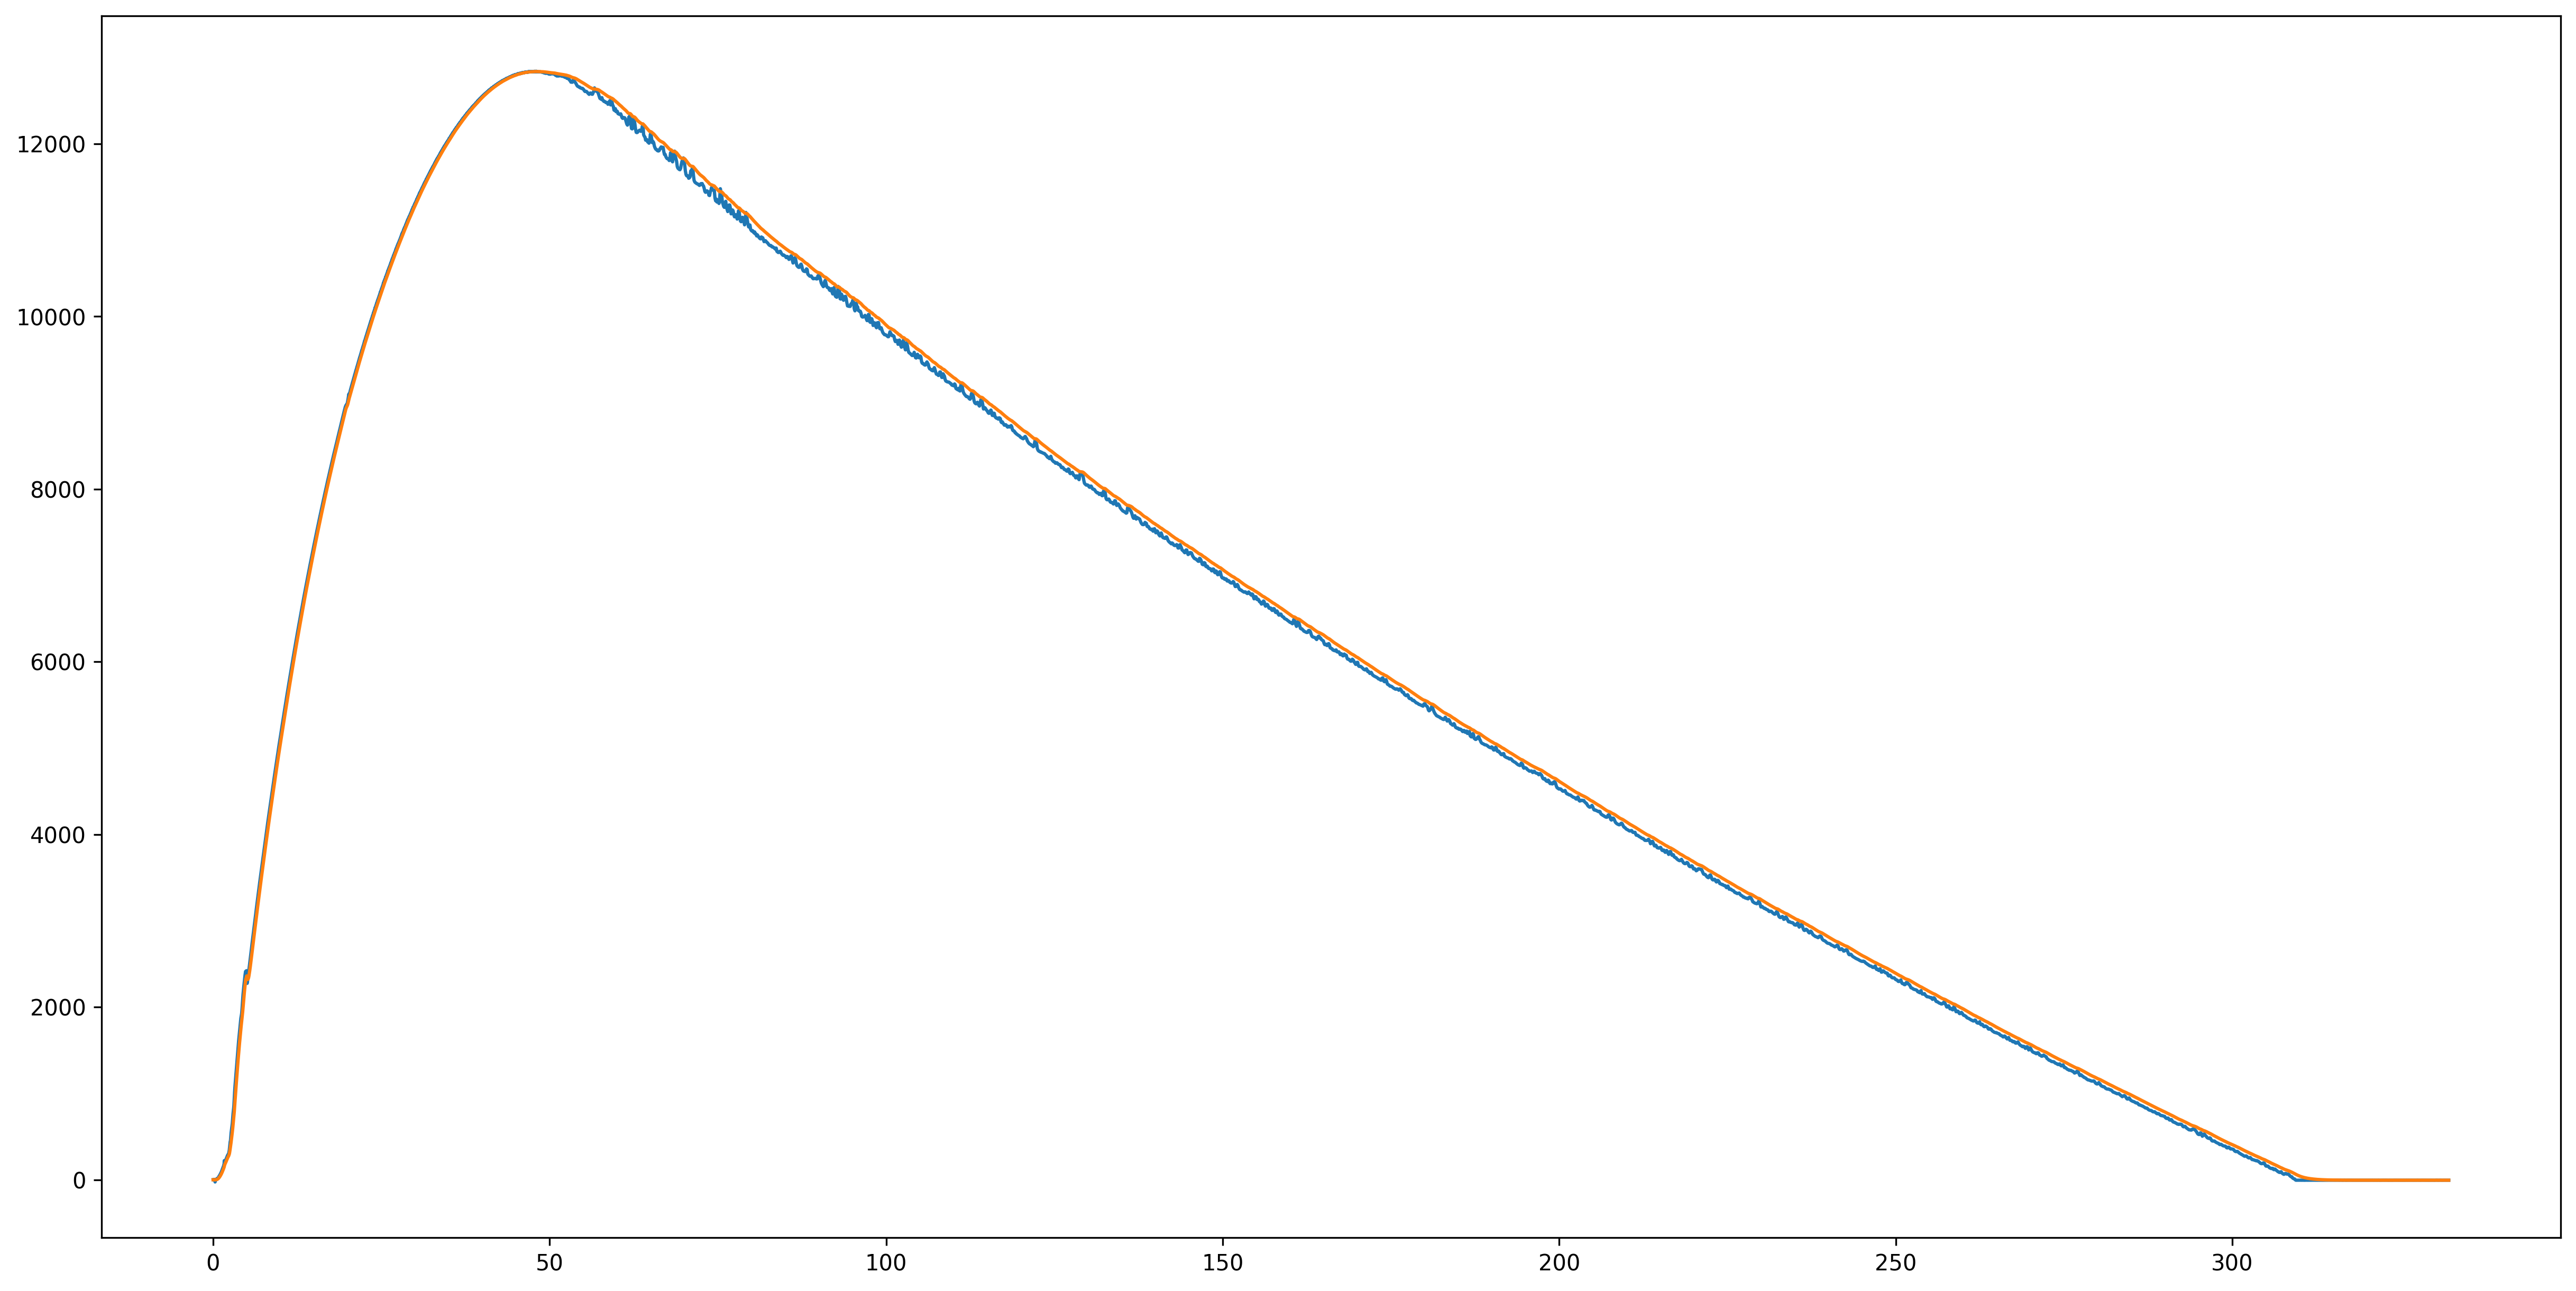

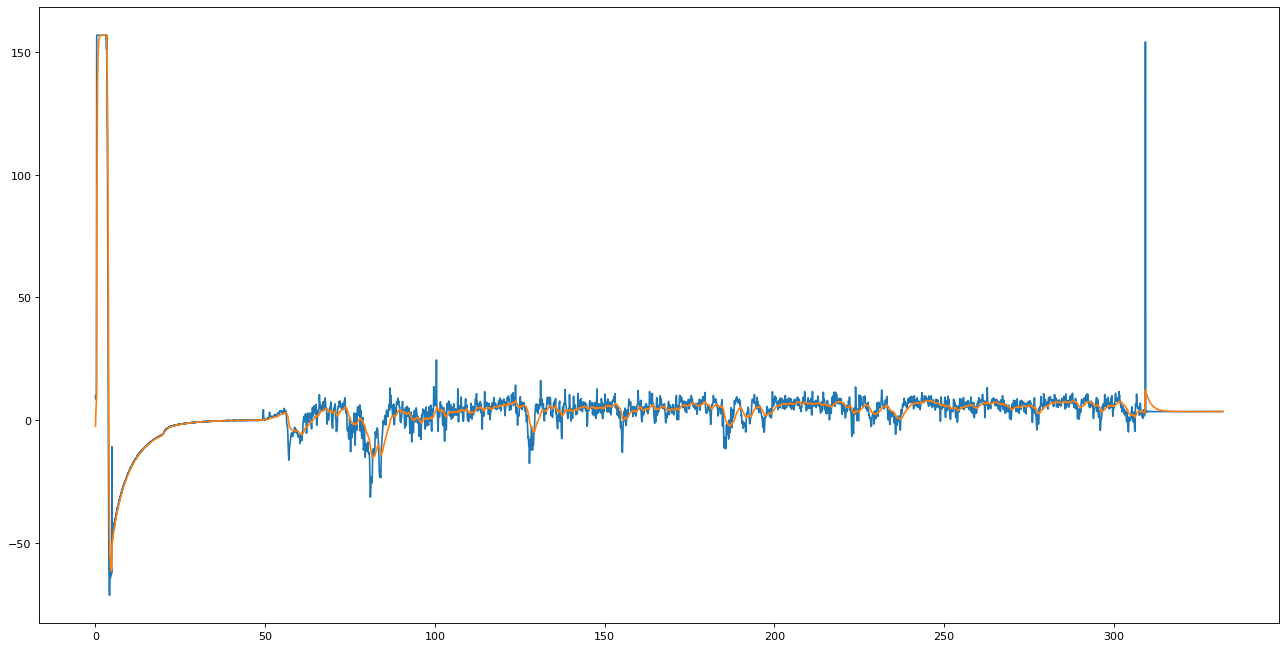

In [3]:
Fig1 = plt.figure(0)
Fig1 = plt.figure(figsize=(20,10), dpi=300)
plt.plot(RawData[:,0], RawData[:,1], label='Raw Position')
print(np.size(RawData[:,0]), np.size(FilteredData[:,0]))
plt.plot(RawData[:,0], FilteredData[:,0], label='Filtered Position')


Fig2 = plt.figure(figsize=(20,10), dpi=80)
plt.plot(RawData[:,0], RawData[:,2], label='Raw Acceleration')
plt.plot(RawData[:,0], FilteredData[:,1], label='Filtered Acceleration')

In [19]:
Q = 0.1; # process noise
R = 0.5; # measurement noise
X = 0.0; P = 1; # initial state

In [20]:
def updateKG(ErrEst, ErrMeas):
    # 2. Calculate Kalman Gains and return them
    KG = ErrEst / (ErrEst + ErrMeas)
    return KG

def updateEst(EstTprev, KG, Meas):
    # 3. Calculate new Altitude estimate and return it
    Est = EstTprev + KG * (Meas - EstTprev)
    return Est

def updateErrEst(KG, ErrEstTprev):
    # 4. Calculate new Error Estimate and return it
    ErrEst = (1 - KG) * ErrEstTprev
    return ErrEst
    
    
def kalman_filter(meas, P, Q, R, X): # prediction update
    P = P + Q # covariance estimate

    # measurement update
    K = P / (P + R) # Kalman gain
    X = X + K * (meas - X) # estimate
    P = (1 - K) * P # covariance update
    print(P, K, meas, X)
    return P, X


def ranKalman(measurements, estimates, Pini, Xini, Q, R):
    j = 0;
    Pnext, Xnext = Pini, Xini
    for i in range(np.size(measurements)):
        #printf("Before filtering: %f\n", measurements[i][types]);
        Pnext, Xnext = kalman_filter(measurements[i], Pnext, Q, R, Xnext);
        estimates[i] = Xnext;
        #printf("After filtering: %f\n\n", X);
        j = j+1;
    
    print("Iteration count: ", j); # Print the number of iterations
    return estimates;

In [21]:
def cal_velocity(position, sensorTime):
    vel_array = np.zeros(len(sensorTime)-1)
    print(np.size(position), np.size(sensorTime))
    for i in range(len(sensorTime)-1):
        vel_array[i] = (position[i+1] - position[i]) / (sensorTime[i+1] - sensorTime[i])
    
    return vel_array

7652 7652


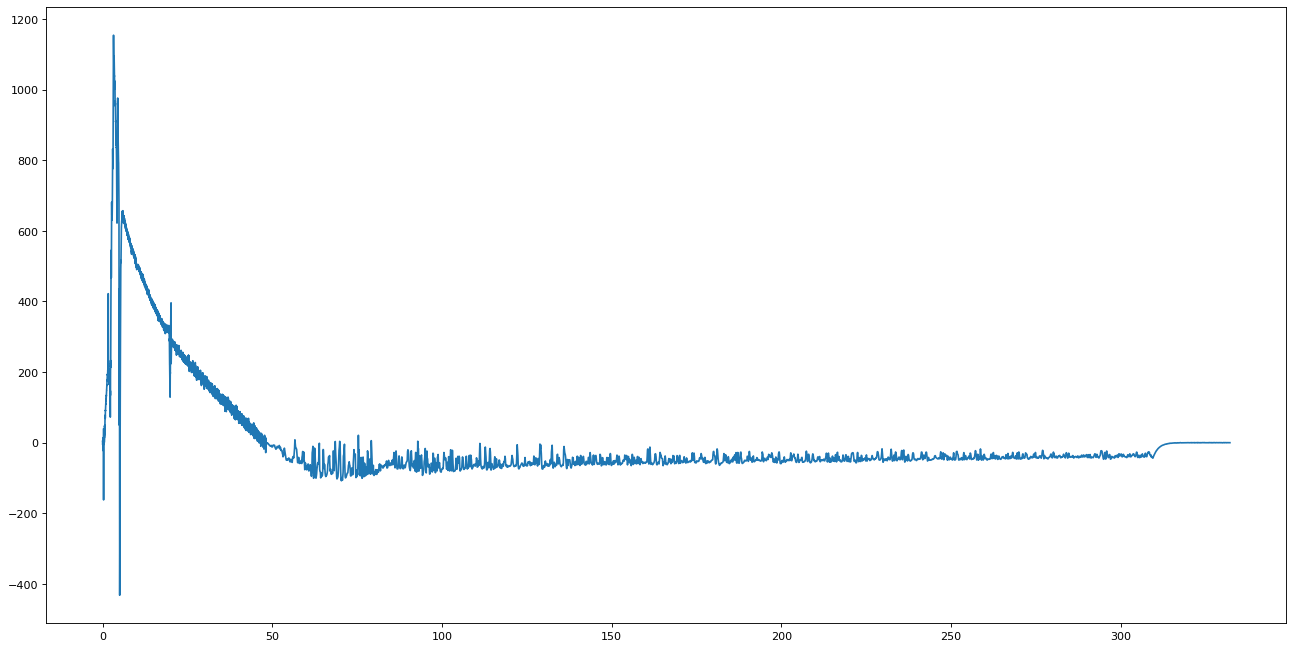

In [22]:
CalcV_fP = cal_velocity(FilteredData[:,0], RawData[:,0])
Fig2 = plt.figure(figsize=(20,10), dpi=80)
plt.plot(RawData[1:,0], CalcV_fP)

In [23]:
filteredVel = ranKalman(CalcV_fP, np.zeros(7651), P, X, Q, R)
print(np.size(filteredVel), np.size(RawData[1:,0]))


0.34375 0.6875 -4.000000000000001 -2.7500000000000004
0.23509933774834438 0.47019867549668876 6.000000000000001 1.3642384105960272
0.20063441712926253 0.40126883425852494 4.999999999999999 2.8231562252180806
0.1877476228209192 0.3754952456418384 2.999999999999999 2.889560221870047
0.18263947391583157 0.36527894783166315 2.000000000000001 2.5646225999924557
0.1805681181027599 0.3611362362055199 2.9999999999999973 2.721853155560124
0.17972045718745575 0.3594409143749115 -22.00000000000001 -6.1641923477167015
0.1793722702854563 0.3587445405709126 14.000000000000009 1.069601572048441
0.1792290288844458 0.3584580577688916 3.9999999999999964 2.120026501020969
0.17917006331514215 0.3583401266302843 -1.0000000000000004 1.001995809555272
0.17914578373773415 0.3582915674754683 -2.000000000000001 -0.07359397460507422
0.17913578534597868 0.35827157069195736 2.9999999999999973 1.0275873663460209
0.17913166780167028 0.3582633356033406 0.0 0.6594404888550435
0.17912997208112708 0.3582599441622541 0.0

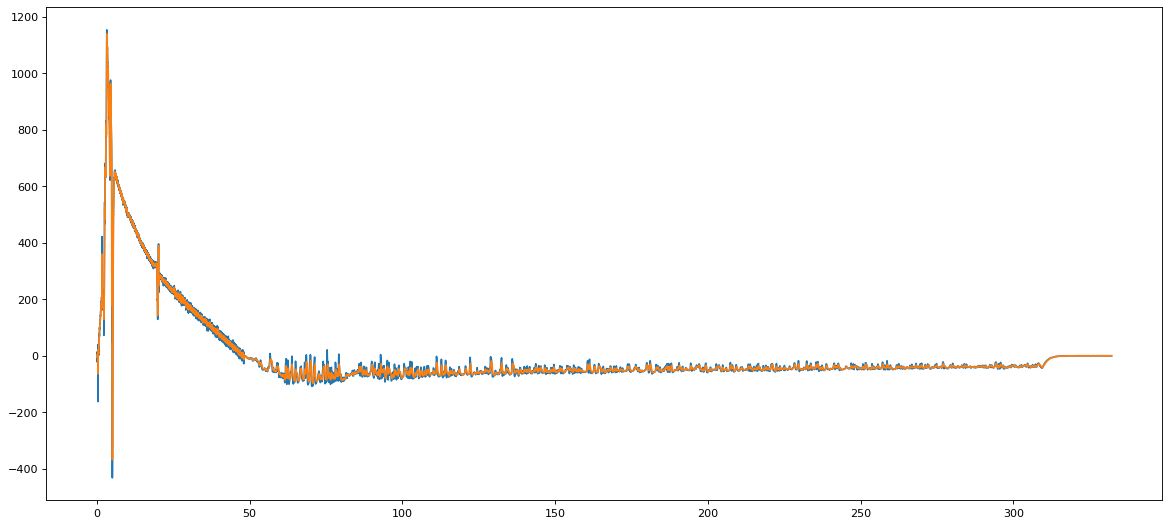

In [24]:
Fig2 = plt.figure(figsize=(18,8), dpi=80)
plt.plot(RawData[1:,0], CalcV_fP)
plt.plot(RawData[1:,0], filteredVel)

In [33]:
def OneDekf_update(x, P, z, H, R):
    # Kalman gain
    K = H * P / (H * P * H + R)

    # Update estimate and uncertainty
    x_new = x + K * (z - H * x)
    P_new = (1 - K * H) * P

    return x_new, P_new

def OneDekf_predict(x, P, F, Q):
    # Predict new state and uncertainty
    x_new = F * x
    P_new = F * P * F + Q

    return x_new, P_new

def OneDekf_initial():
    # Initialize state
    x = 0
    P = 1

    # Process noise
    Q = 0.1

    # Measurement noise
    R = 0.5

    # State transition and measurement derivatives
    F = 1
    H = 1

    # Generate some measurements
    return x, P, Q, R, F, H

def OneDran_ekf(measurements, estimates):
    x, P, Q, R, F, H = OneDekf_initial()
    
    for i in range(np.size(measurements)):
        # Update step
        x, P = OneDekf_update(x, P, measurements[i], H, R)
        print(f"Update: {x}")

        # Prediction step
        x, P = OneDekf_predict(x, P, F, Q)
        estimates[i] = x
        print(f"Predict: {x}")

    return estimates


In [34]:
EKFVel = np.zeros(np.size(CalcV_fP))
EKFVel = OneDran_ekf(CalcV_fP, EKFVel)

Update: -2.666666666666667
Predict: -2.666666666666667
Update: 1.3571428571428577
Predict: 1.3571428571428577
Update: 2.8111587982832615
Predict: 2.8111587982832615
Update: 2.8819108964036495
Predict: 2.8819108964036495
Update: 2.560062721570766
Predict: 2.560062721570766
Update: 2.7188798759290065
Predict: 2.7188798759290065
Update: -6.164710321354139
Predict: -6.164710321354139
Update: 1.0688042736868528
Predict: 1.0688042736868528
Update: 2.119487171677277
Predict: 2.119487171677277
Update: 1.0016619376206313
Predict: 1.0016619376206313
Update: -0.07380339130024449
Predict: -0.07380339130024449
Update: 1.0274509400897767
Predict: 1.0274509400897767
Update: 0.6593532196160059
Predict: 0.6593532196160059
Update: 0.4231334461033846
Predict: 0.4231334461033846
Update: -0.44497471040652287
Predict: -0.44497471040652287
Update: -0.28555898143695757
Predict: -0.28555898143695757
Update: -0.5415129971886126
Predict: -0.5415129971886126
Update: 0.010745802846095498
Predict: 0.010745802846095

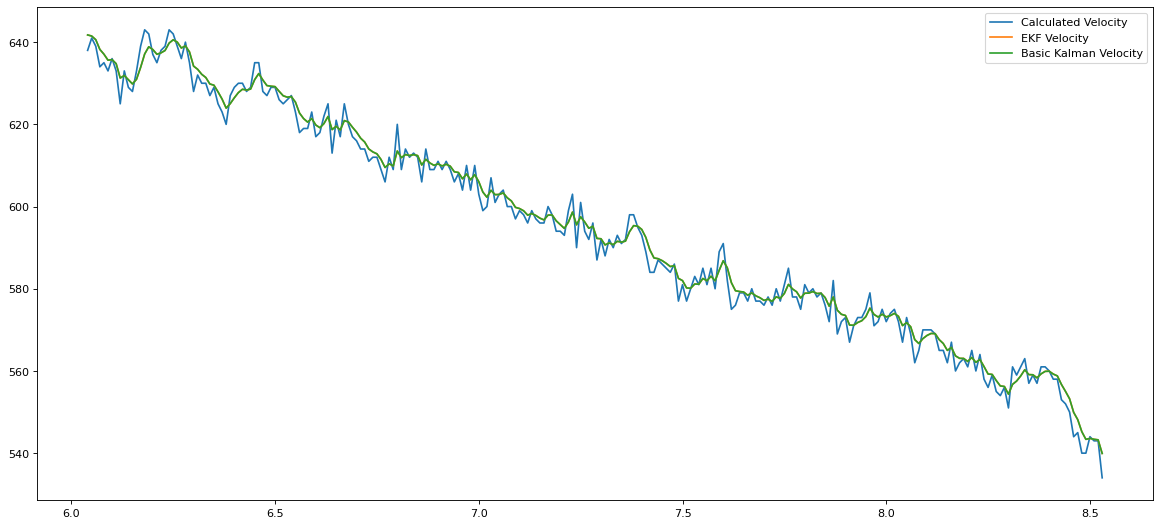

In [32]:
Fig3 = plt.figure(figsize=(18,8), dpi=80)
indexrange = 250
startindex = 600
endindex = startindex + indexrange
plt.plot(RawData[1+startindex:1+endindex,0], CalcV_fP[startindex:endindex], label='Calculated Velocity')
plt.plot(RawData[1+startindex:1+endindex,0], EKFVel[startindex:endindex], label='EKF Velocity')
plt.plot(RawData[1+startindex:1+endindex,0], filteredVel[startindex:endindex], label='Basic Kalman Velocity')
plt.legend()

In [92]:
def ekf_update(x, P, z, H, R):
    # Kalman gain
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

    # Update estimate and uncertainty
    x_new = x + K @ (z - H @ x)
    P_new = (np.eye(len(x)) - K @ H) @ P

    return x_new, P_new

def ekf_predict(x, P, Q, dt):
    # Predict new state and uncertainty
    F = np.array([[1, dt], [0, 1]])
    x_new = F @ x
    P_new = F @ P @ F.T + Q

    return x_new, P_new

# Initialize state (position and velocity)
def ekf_initial():
    x = np.array([0, 0])
    P = np.eye(2)

    # Process noise
    Q = np.eye(2) * 0.1

    # Measurement noise
    R = np.eye(2) * 0.5

    # State transition and measurement matrices
    #F = np.array([1, dt, 0.5*dt**2, dt])
    H = np.array([[1, 0], [0, 1]])

    return x, P, Q, R, H

def run_ekf(measurements, estimates):

    x, P, Q, R, H = ekf_initial()
    for i in range(np.size(measurements[:,0])-1):
        # Update step
        x, P = ekf_update(x, P, measurements[i,1:], H, R)
        print(measurements[i,1:])
        print(f"Update: {x}")

        # Prediction step
        dt = measurements[i+1,0] - measurements[i,0]
        [estimates[i,0], estimates[i,1]], P = ekf_predict(x, P, Q, dt)
        print(f"Predict: {x}")

    return estimates


In [93]:
EKFPosAccel = np.zeros((np.size(RawData[:,0]),2))
print(EKFPosAccel.shape)
EKFPosAccel=run_ekf(RawData, EKFPosAccel)

(7652, 2)
[-0.19  9.66]
Update: [-0.12666667  6.44      ]
Predict: [-0.12666667  6.44      ]
[-0.19  9.79]
Update: [-0.14966292  7.99521308]
Predict: [-0.14966292  7.99521308]
[0.09 9.81]
Update: [-0.04970202  8.72011594]
Predict: [-0.04970202  8.72011594]
[0.18 9.83]
Update: [0.03912644 9.13650511]
Predict: [0.03912644 9.13650511]
[0.18 9.87]
Update: [0.09238654 9.40453224]
Predict: [0.09238654 9.40453224]
[0.09 9.89]
Update: [0.09274646 9.57977193]
Predict: [0.09274646 9.57977193]
[0.28 8.54]
Update: [0.15743661 9.20658166]
Predict: [0.15743661 9.20658166]
[-1.77  9.97]
Update: [-0.53214208  9.47558266]
Predict: [-0.53214208  9.47558266]
[1.12 9.88]
Update: [0.0611526  9.62468555]
Predict: [0.0611526  9.62468555]
[0.37 9.39]
Update: [0.17124839 9.54136805]
Predict: [0.17124839 9.54136805]
[-0.1 10.3]
Update: [0.07595412 9.81248516]
Predict: [0.07595412 9.81248516]
[-0.19 10.01]
Update: [-0.01884564  9.88257857]
Predict: [-0.01884564  9.88257857]
[ 0.37 10.02]
Update: [0.120825   9.93

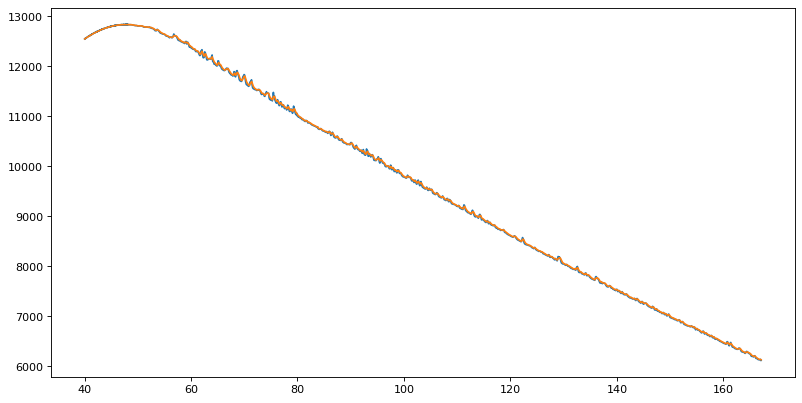

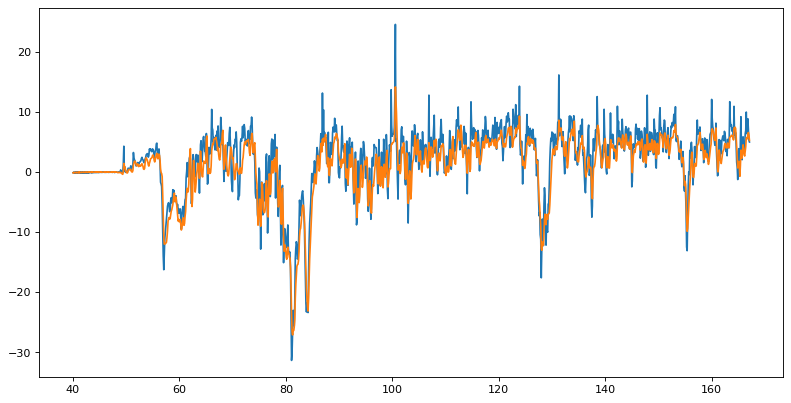

In [96]:
Fig4 = plt.figure(figsize=(12,6), dpi=80)
indexrange = 2000
startindex = 4000
endindex = startindex + indexrange
plt.plot(RawData[1+startindex:1+endindex,0], RawData[startindex:endindex,1], label='raw position')
plt.plot(RawData[1+startindex:1+endindex,0], EKFPosAccel[startindex:endindex,0], label='EKF position')

Fig5 = plt.figure(figsize=(12,6), dpi=80)
#indexrange = 7561
#startindex = 0
endindex = startindex + indexrange
plt.plot(RawData[1+startindex:1+endindex,0], RawData[startindex:endindex,2], label='raw acceleration')
plt.plot(RawData[1+startindex:1+endindex,0], EKFPosAccel[startindex:endindex,1], label='EKF acceleration')

In [13]:
def ukf_update(x, P, z, R):
    # Calculate sigma points
    sigma_points = np.array([x, x + np.sqrt(P), x - np.sqrt(P)])

    # Calculate new mean and covariance
    x_new = np.mean(sigma_points)
    P_new = np.var(sigma_points) + R

    # Update estimate and uncertainty
    x_new += (z - x_new) / 2
    P_new += (z - x_new)**2 / 2

    return x_new, P_new

def ukf_predict(x, P, Q):
    # Predict new state and uncertainty
    x_new = x
    P_new = P + Q

    return x_new, P_new